# Open and plot a FITS spectrum

This notebook locates a local FITS spectrum, reads the data and header, builds a wavelength array (from WAVE extension or header keywords), and plots the spectrum. It uses `astropy` and `numpy`.

Usage:
- Put the FITS file in `data/` and update the `filename` variable below or use the file finder cell.

In [20]:
# Imports
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u

# helper: find candidates in data/ (project data directory is one level up from notebooks/)
nb_dir = os.getcwd()
project_dir = os.path.dirname(nb_dir)
data_dir = os.path.join(project_dir, 'data')
print('project dir:', project_dir)
print('data dir:', data_dir)
files = glob(os.path.join(data_dir, '*.fits')) + glob(os.path.join(data_dir, '*.FITS'))
print('found', len(files), 'fits file(s)')
files[:10]

project dir: /home/mathis/Documents/s4
data dir: /home/mathis/Documents/s4/data
found 2 fits file(s)


['/home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits',
 '/home/mathis/Documents/s4/data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits']

In [21]:
# Choose a file (edit this if you want a specific name)
if len(files) == 0:
    raise FileNotFoundError('No FITS files found in data/ — download or place the file first')

filename = files[0]
print('Using file:', filename)

# read header and data
with fits.open(filename) as hdul:
    hdul.info()
    # look for data extensions with 1D arrays
    data_ext = None
    wave_ext = None
    for i, hdu in enumerate(hdul):
        shape = getattr(hdu, 'data', None)
        if shape is None:
            continue
        if isinstance(shape, np.ndarray) and shape.ndim == 1 and data_ext is None:
            data_ext = i
        # Some model grids store wavelength in a separate extension named 'WAVE'
        if hdu.name.upper() == 'WAVE':
            wave_ext = i
    print('data_ext=', data_ext, 'wave_ext=', wave_ext)

    # load flux
    flux = hdul[data_ext].data.astype(float)
    header = hdul[data_ext].header
    print('flux shape:', flux.shape)

    # attempt to build wavelength
    wavelength = None
    if wave_ext is not None:
        wavelength = hdul[wave_ext].data.astype(float)
    else:
        # try standard FITS WCS-like keywords
        if 'CRVAL1' in header and 'CDELT1' in header and 'NAXIS1' in header:
            crval = header['CRVAL1']
            cdelt = header['CDELT1']
            naxis1 = header['NAXIS1']
            wavelength = crval + cdelt * np.arange(naxis1)
        elif 'CRVAL' in header and 'CDELT' in header and 'NAXIS' in header:
            crval = header['CRVAL']
            cdelt = header['CDELT']
            naxis1 = header['NAXIS']
            wavelength = crval + cdelt * np.arange(naxis1)
    
    if wavelength is None:
        # fallback: create pixel index array
        wavelength = np.arange(flux.size)

print('wavelength length:', wavelength.size)

Using file: /home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Filename: /home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1569128,)   float32   
  1  ABUNDANCES    1 BinTableHDU     15   83R x 3C   [I, 2A, E]   
data_ext= 0 wave_ext= None
flux shape: (1569128,)
wavelength length: 1569128


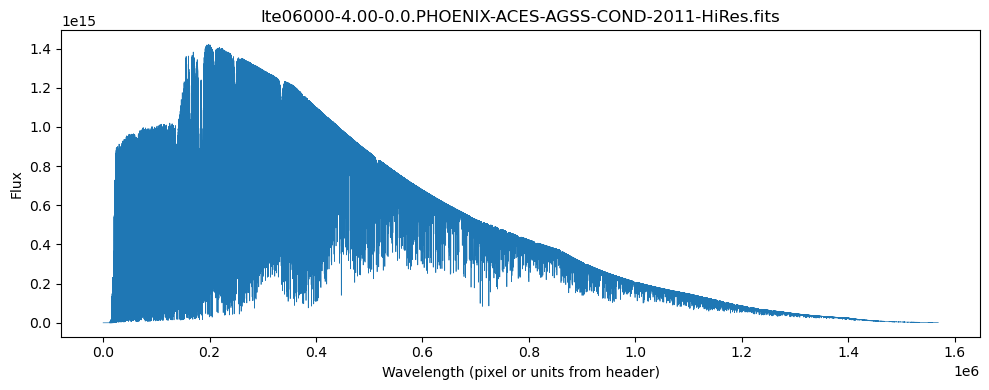

In [22]:
# Simple plot
plt.figure(figsize=(10,4))
plt.plot(wavelength, flux, lw=0.5)
plt.xlabel('Wavelength (pixel or units from header)')
plt.ylabel('Flux')
plt.title(os.path.basename(filename))
plt.tight_layout()
plt.show()

## Optional: smoothing example

If the spectrum is noisy, you can smooth it with a simple boxcar or Gaussian convolution. Below is a tiny boxcar smoother.

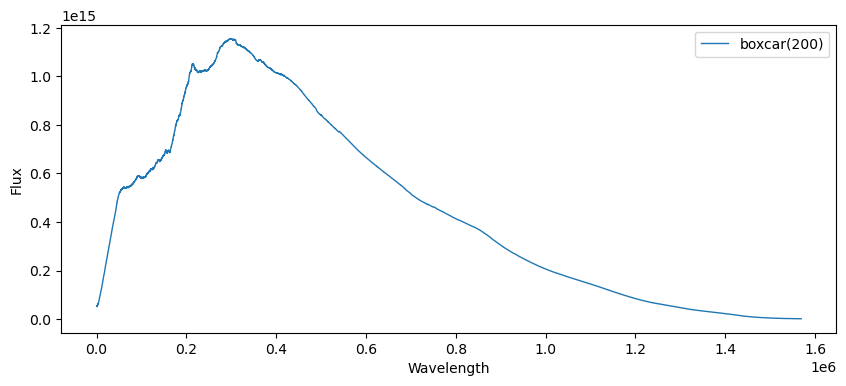

In [23]:
from scipy.ndimage import uniform_filter1d

flux_smooth = uniform_filter1d(flux, size=50000)
plt.figure(figsize=(10,4))
#plt.plot(wavelength, flux, alpha=0.4, lw=0.5, label='raw')
plt.plot(wavelength, flux_smooth, lw=1, label='boxcar(200)')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()

In [25]:
# Print full metadata for all HDUs and save to a CSV file
from astropy.io import fits
import csv

rows = []
with fits.open(filename) as hdul:
    for i, hdu in enumerate(hdul):
        hdr = hdu.header
        hdu_name = hdu.name
        for card in hdr.cards:
            keyword = card.keyword
            value = card.value
            comment = card.comment
            rows.append((i, hdu_name, keyword, value, comment))

# Print summary to notebook
print(f'Collected {len(rows)} header cards from {len(hdul)} HDUs')

# Write CSV
csv_file = os.path.join(project_dir, 'data', os.path.basename(filename) + '.metadata.csv')
with open(csv_file, 'w', newline='') as cf:
    writer = csv.writer(cf)
    writer.writerow(['hdu_index', 'hdu_name', 'keyword', 'value', 'comment'])
    for r in rows:
        # convert value to string safely
        writer.writerow([r[0], r[1], r[2], str(r[3]), r[4]])

print('Wrote metadata CSV to', csv_file)

Collected 39 header cards from 2 HDUs
Wrote metadata CSV to /home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits.metadata.csv
